In [1]:
import numpy as np
import theano
import theano.tensor as T
import scipy.sparse as sp
from theano import sparse
import lasagne
import time
import scipy.stats as stats
from collections import OrderedDict
import sys 
sys.setrecursionlimit(50000)


/Applications/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
# Generate a matrix from a multivariate normal distribution with low-rank covariance matrix
KTRUE = 10
K = 20
N = 100
D = 50
maxit = 3*KTRUE*(N+D-KTRUE)

np.random.seed(seed=10)

#w   = np.random.uniform(low=0.0, high=1.0, size=(D,KTRUE))
w     = np.random.beta(a = 2, b = 5, size = (D,KTRUE))
maskw = stats.bernoulli.rvs(0.8, size=(D,KTRUE))
w     = np.multiply(w,maskw)
var = 0.1
covnp = w.dot(w.T)+var*np.eye(D)

Mnp = np.random.multivariate_normal(np.zeros(D), covnp, N).T

In [3]:
# We use Theano for our model
srng = T.shared_randomstreams.RandomStreams(seed=120)

#Define Theano Variables
Shared = lambda shape,name: theano.shared(value = np.ones(shape,dtype=theano.config.floatX),
                                          name=name,borrow=True) 


In [4]:
# Let Ynp represent our matrix of partial, noisy observations
prob     = (maxit/15)/(N*D)
#p = 1
#Masknp = np.random.binomial(N, p, size=(N,D)).T
Masknp = np.zeros(N*D)
observe = np.random.permutation(np.arange(N*D))[1:int(np.floor(prob*N*D))]
Masknp[observe] = 1
observerow = np.random.randint(0, high=D, size=np.maximum(N,D))
observecol = np.arange(N)
Masknp = Masknp.reshape((D,N))
Masknp[observerow, observecol] = 1
initial_obs = np.multiply([Masknp!=0], Mnp).flatten()
ratings = initial_obs[initial_obs!=0].tolist()
#p = 0.08
#Masknp = np.random.binomial(N, p, size=(N,D)).T
#Masknp = stats.bernoulli.rvs(p, size=(D,N))
#Masknp[1,:] = 1
Mask   = Shared((D,N), 'Mask')
Mask.set_value(Masknp)
M      = T.as_tensor_variable(Mnp)
Y      = Mask*M
zeroY  = T.as_tensor_variable(np.zeros((D,N)))
zero2  = T.as_tensor_variable(np.zeros((D,D)))
zero   = T.as_tensor_variable(np.zeros(D))
st     = T.sum(T.neq(Y, zeroY), axis = 0)
s      = st.eval()

In [5]:
#Define variational parameters
mW=Shared((D,K), "mW")
sW=Shared((D,K), "sW")
mr=Shared((K), "mr")
sr=Shared((K), "sr")
mGamma=Shared((1), "mGamma")
sGamma=Shared((1), "sGamma")
mGamma0=Shared((1), "mGamma0")
sGamma0=Shared((1), "sGamma0")
mc0=Shared((1), "mc0")
sc0=Shared((1), "sc0")
msigma=Shared((1), "msigma")
ssigma=Shared((1), "ssigma")

#Define model parameters and other random variables (zY, zK, error, KmatrixRandom)
zW= srng.normal((D,K))
zr= srng.normal([K])
zGamma= srng.normal([1])
zGamma0= srng.normal([1])
zc0= srng.normal([1])
zsigma=srng.normal([1])
zY=srng.normal([D])
zK=srng.normal([K])
KmatrixRandom=srng.uniform(size=(D,D), low=0, high=1000)

#All variables have a log-normal variational posterior
W=T.exp(mW+zW*sW)
r=T.exp(mr + zr*sr)
Gamma=T.exp(mGamma + zGamma*sGamma)
Gamma0=T.exp(mGamma0 + zGamma0*sGamma0)
c0=T.exp(mc0 + zc0*sc0)
sigma=T.exp(msigma +zsigma*ssigma)


#For data given seqentially we need a different covariance matrix for each yn
WWT=T.dot(W, W.T)
Cov=Shared((D,D), 'Cov')
Cov=WWT+sigma[0]*T.identity_like(WWT)


#Define lists
vParams= [mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma]
mParams = [W, r, Gamma, Gamma0, c0, sigma]

#indexlist = Shared([maxit], 'indexlist')
indexlist = theano.shared(value = np.zeros([maxit],dtype=np.int64),
                                          name='indexlist',borrow=True)

Estimates = Shared((maxit, N, D), 'Estimates')

In [6]:
#Define Functions for Variational Inference

def Entropy(vParams):
    
    mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma= vParams
    entW      = T.log(T.abs_(sW))+mW
    entr      = T.log(T.abs_(sr))+mr
    entGamma  = T.log(T.abs_(sGamma))+mGamma
    entGamma0 = T.log(T.abs_(sGamma0))+mGamma0
    entc0     = T.log(T.abs_(sc0))+mc0
    entsigma  = T.log(T.abs_(ssigma))+msigma
    entropy   = entW.sum()+entr.sum()+entGamma+entGamma0+entc0+entsigma
    
    return(entropy)


"""
def logJointScanFn2(n, logLikelihood, Y, Cov, s):
    
    idxs          = T.neq(Y[:,n], zero).nonzero()
    y             = Y[:,n][idxs]
    idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    logLikelihood +=(-1/2.0)*T.log(T.nlinalg.Det()(littlecov))-(1/2.0)*T.dot(y.T, T.dot(T.nlinalg.MatrixInverse()(littlecov), y))
    
    return logLikelihood



def LogJ2(mParams,vParams,Y, Cov, s):
    
    mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma = vParams
    W, r, Gamma, Gamma0, c0, sigma = mParams
    #LogJt0=time.clock()
    results, updates = theano.scan(fn=logJointScanFn2,
                                   sequences = np.arange(N),
                                   outputs_info=[dict(initial= np.float64(0) ,taps=[-1])],
                                   non_sequences=[Y, Cov, s])
    logJoint  = results[-1]
    logJoint2 = ((D*Gamma*T.log(Gamma))[0]*r).sum()-(D*T.gammaln(Gamma[0]*r)).sum()+((Gamma[0]*r-1)*T.log(W)).sum()-(Gamma[0]*W).sum() + (Gamma0*T.log(c0)-K*T.gammaln(Gamma0/K)+(Gamma0/K-1)[0]*(T.log(r)).sum()-(c0[0]*r).sum()-Gamma-Gamma0-c0)[0]
    logJoint  += logJoint2

    return(logJoint)
"""

def logJointScanFn(n, logLikelihood, Y, Cov, Mask):
    
    #idxs          = T.neq(Y[:,n], zero).nonzero()
    #y             = Y[:,n][idxs]
    #idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    
    #littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    #logLikelihood +=(-1/2.0)*T.log(T.nlinalg.Det()(littlecov))-(1/2.0)*T.dot(y.T, T.dot(T.nlinalg.MatrixInverse()(littlecov), y))
    
    #numpy_IncompleteId=np.zeros((D,D))
    #Mask=C.gpu_from_host(T.outer(Yobs_theano[:,n], Yobs_theano[:,n]).reshape((D,D)))
    
    Partial_Cov    = T.outer(Mask[:,n], Mask[:,n])*Cov + (1-Mask[:,n])*T.identity_like(Cov)
    logLikelihood += (-1/2.0)*T.log(T.nlinalg.Det()(Partial_Cov))-(1/2.0)*T.dot(Y[:,n].T, T.dot(T.nlinalg.MatrixInverse()(Partial_Cov), Y[:,n]))
    
    return logLikelihood

def LogJ(mParams, Y, Cov, Mask):

    W, r, Gamma, Gamma0, c0, sigma = mParams
    #LogJt0=time.clock()
    
    results, updates = theano.scan(fn=logJointScanFn,
                                   sequences = np.arange(N),
                                   outputs_info=[dict(initial= np.float64(0) ,taps=[-1])],
                                   non_sequences=[Y, Cov, Mask])
    
    #logLikelihood = sigma[0]
    #for n in range(N):
    #    logLikelihood = logJointScanFn(n, logLikelihood, Y, Cov, s)
    logJoint = results[-1]
    
    #logJoint  = results[-1]
    logJoint2 = ((D*Gamma*T.log(Gamma))[0]*r).sum()-(D*T.gammaln(Gamma[0]*r)).sum()+((Gamma[0]*r-1)*T.log(W)).sum()-(Gamma[0]*W).sum() + (Gamma0*T.log(c0)-K*T.gammaln(Gamma0/K)+(Gamma0/K-1)[0]*(T.log(r)).sum()-(c0[0]*r).sum()-Gamma-Gamma0-c0)[0]
    logJoint  += logJoint2

    return(logJoint)


    
def ELBO(mParams,vParams, Y, Cov, s):
    
    return(LogJ(mParams,Y, Cov,Mask)+Entropy(vParams)[0])

In [7]:
def adadelta2(loss_or_grads,mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma, learning_rate=1.0, rho=0.95, epsilon=1e-6):
    """ 
    References
    ----------
    .. [1] Zeiler, M. D. (2012):
           ADADELTA: An Adaptive Learning Rate Method.
           arXiv Preprint arXiv:1212.5701.
    """
    params = [mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma]
    grads = get_or_compute_grads(loss_or_grads, params)
    updates = OrderedDict()

    # Using theano constant to prevent upcasting of float32
    one = T.constant(1)

    for param, grad in zip(params, grads):
        value = param.get_value(borrow=True)
        # accu: accumulate gradient magnitudes
        accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                             broadcastable=param.broadcastable)
        # delta_accu: accumulate update magnitudes (recursively!)
        delta_accu = theano.shared(np.zeros(value.shape, dtype=value.dtype),
                                   broadcastable=param.broadcastable)

        # update accu (as in rmsprop)
        accu_new = rho * accu + (one - rho) * grad ** 2
        updates[accu] = accu_new
        #accu = accu_new

        # compute parameter update, using the 'old' delta_accu
        update = (grad * T.sqrt(delta_accu + epsilon) /
                  T.sqrt(accu_new + epsilon))
        updates[param] = param - learning_rate * update
        #updates[param] = T.minimum(T.maximum((param - learning_rate * update).astype(theano.config.floatX), (1e-10)*T.ones_like(param)), 10*T.ones_like(param))
        #param = T.minimum(T.maximum((param - learning_rate * update).astype(theano.config.floatX), (1e-10)*T.ones_like(param)), 10*T.ones_like(param))
        # update delta_accu (as accu, but accumulating updates)
        delta_accu_new = rho * delta_accu + (one - rho) * update ** 2
        updates[delta_accu] = delta_accu_new
        #delta_accu = delta_accu_new

    return updates

def get_or_compute_grads(loss_or_grads, params):
    """Helper function returning a list of gradients
    """
    if any(not isinstance(p, theano.compile.SharedVariable) for p in params):
        raise ValueError("params must contain shared variables only. If it "
                         "contains arbitrary parameter expressions, then "
                         "lasagne.utils.collect_shared_vars() may help you.")
    if isinstance(loss_or_grads, list):
        if not len(loss_or_grads) == len(params):
            raise ValueError("Got %d gradient expressions for %d parameters" %
                             (len(loss_or_grads), len(params)))
        return loss_or_grads
    else:
        return theano.grad(loss_or_grads, params)
    
    


In [8]:
#Gradient Descent- to do "limit" steps of gradient descent call AdaDeltaStep2()
limit   = 200
elbo    = ELBO(mParams,vParams,Y,Cov,s)
#entropy = Entropy(vParams)
#logJ    = LogJ(mParams,vParams,Y,Cov,s)


[results, vParam_updates] = theano.scan(fn = adadelta2, 
                                      sequences = None,
                                      non_sequences = [-elbo ,mW, sW, mr, sr, mGamma, sGamma, mGamma0, sGamma0, mc0, sc0, msigma, ssigma],
                                      outputs_info = None,
                                      n_steps = limit)

AdaDeltaStep2=theano.function(inputs=[], updates=vParam_updates)

In [9]:
Ytrue = Y.eval()

In [10]:
"""
#Stochastic Gradient Descent

elbo=ELBO(mParams,vParams, Y, Cov, s)
entropy=Entropy(vParams)
logJ=LogJ2(mParams,vParams, Y, Cov, s)
#paramt0=time.clock()
vParamUpdates=lasagne.updates.adadelta(-elbo,vParams)
#paramt1=time.clock()
AdaDeltaStep=theano.function(inputs=[], updates=vParamUpdates)


def SGD(Y, limit,construct_elbo_list, construct_error_list):
    
    #Repeat Code as above to construct the partial covariance matrices, also construct binaryY
    #which is a matrix with a 1 in the (i,j) entry if we have observed that entry
    elbo=ELBO(mParams,vParams, Y, Cov, s)
    entropy=Entropy(vParams)
    logJ=LogJ2(mParams,vParams, Y, Cov, s)
    #paramt0=time.clock()
    vParamUpdates=lasagne.updates.adadelta(-elbo,vParams)
    #paramt1=time.clock()

    
    #%%time
    counter = 0
    ELBOlist = []
    errorlist = []
    keepUpdating = True
    if construct_elbo_list==1:
        while keepUpdating:
            AdaDeltaStep()
            keepUpdating = False if counter>limit else True 
            # if construct_elbo_list==1, estimate ELBO by Monte Carlo every 20 steps
            if counter%20==0:
                ELBOlist.append(np.mean([elbo.eval() for i in range(40)]))
                R = 10
                [y_estimate, sigma_u_o_scan, sigma_ob_inv_scan], updates=theano.scan(fn=MVNormalScan_beta02,
                                              sequences=T.arange(N),
                                              outputs_info=None,
                                              non_sequences=[Y, Mask, Cov, W, zY, zK, s])
                Yest = y_estimate.eval().T
                errorlist.append(np.linalg.norm(Yest- Ytrue))                
            counter +=1
    else:
        while keepUpdating:
            AdaDeltaStep()
            keepUpdating = False if counter>limit else True 
            counter += 1
    print(counter)
    
    return ELBOlist, errorlist
"""

'\n#Stochastic Gradient Descent\n\nelbo=ELBO(mParams,vParams, Y, Cov, s)\nentropy=Entropy(vParams)\nlogJ=LogJ2(mParams,vParams, Y, Cov, s)\n#paramt0=time.clock()\nvParamUpdates=lasagne.updates.adadelta(-elbo,vParams)\n#paramt1=time.clock()\nAdaDeltaStep=theano.function(inputs=[], updates=vParamUpdates)\n\n\ndef SGD(Y, limit,construct_elbo_list, construct_error_list):\n    \n    #Repeat Code as above to construct the partial covariance matrices, also construct binaryY\n    #which is a matrix with a 1 in the (i,j) entry if we have observed that entry\n    elbo=ELBO(mParams,vParams, Y, Cov, s)\n    entropy=Entropy(vParams)\n    logJ=LogJ2(mParams,vParams, Y, Cov, s)\n    #paramt0=time.clock()\n    vParamUpdates=lasagne.updates.adadelta(-elbo,vParams)\n    #paramt1=time.clock()\n\n    \n    #%%time\n    counter = 0\n    ELBOlist = []\n    errorlist = []\n    keepUpdating = True\n    if construct_elbo_list==1:\n        while keepUpdating:\n            AdaDeltaStep()\n            keepUpdatin

In [11]:
#MVNormalScan constructs our estimate of the entire matrix using conditional multivariate normal

def MVNormalScan_beta02(n, Y, Mask, Cov, W, zY, zK, s):
    
    #construct binaryY_unobs a vector of 1s and 0s where the ith coord is a 1 if we haven't seen the ith coord of y_n    
    binaryY_unobs = T.eq(Y[:,n], zero)
    #construct covariance of the observed entries where the rows/columns with nothing have a 1 on diag (so invertible)
    idxs          = T.neq(Y[:,n], zero).nonzero()
    y             = Y[:,n][idxs]
    idxs2         = T.neq(T.outer(Y[:,n], Y[:,n]), zero2).nonzero()
    littlecov     = Cov[idxs2].reshape((s[n], s[n]))
    littlecov_inv = T.nlinalg.MatrixInverse()(littlecov)
    
    
    #sigma_observed     = T.outer(binaryY[:,n], binaryY[:,n])*Cov+(binaryY_unobs*T.identity_like(Cov))
    sigma_unobs_obs         = (T.outer(binaryY_unobs, T.neq(Y[:,n], zero)))*Cov
    idxs3                   = T.neq(sigma_unobs_obs, zero2).nonzero()
    little_sigma_unobs_obs = sigma_unobs_obs[:,idxs].reshape((D, s[n])) 
    #sigma_observed_inv = T.nlinalg.MatrixInverse()(sigma_observed)
    dummyY             = T.zeros(D)
    
     
    #draw the mean vector dummyY from N(0, WWT+sigma^2I) using computationally fast trick
    dummy_results, dummy_updates= theano.scan(lambda prior_result, sigma, zY, W, zK: 
                                              T.sqrt(sigma)[0]*zY+T.dot(W,zK) + prior_result,
                                              sequences=None,
                                              outputs_info= T.zeros(D),
                                              non_sequences=[sigma, zY, W, zK],
                                              n_steps=R)
    
    dummyY       = dummy_results[-1]
    dummyY       /= R
    dummyY_obs   = dummyY[idxs]
    dummyY_unobs = binaryY_unobs*dummyY
    y_est        = dummyY_unobs + T.dot(T.dot(little_sigma_unobs_obs, littlecov_inv), (y-dummyY_obs))
    y_est        = (y_est*binaryY_unobs)-(1e6)*Mask[:,n]
    #y_est        = y_est*binaryY_unobs + Y[:,n]*Mask[:,n]
    
    return [y_est, sigma_unobs_obs, littlecov_inv]



In [12]:
def MainBandit2(count, indexlist, Mask, Masknp, Y):
    
    limit = 500
    R     = 10
    construct_elbo_list = 0
    
    AdaDeltaStep2()
    
    [y_est, sigma_u_o_scan, sigma_ob_inv_scan], updates=theano.scan(fn=MVNormalScan_beta02,
                                              sequences=T.arange(N),
                                              outputs_info=None,
                                              non_sequences=[Y, Mask, Cov, W, zY, zK, s])

    [value, index] = T.max_and_argmax(y_est.T)
    
    indnp = index.eval()
    
    #print('index choice')
    #print(time.clock() - tt)
    
    #mf = Masknp.flatten()
    #mf[indnp] = 1
    #Masknp = mf.reshape((D,N))
    #Masknp[row_ind, col_ind] = 1
    #Mask.set_value(Masknp)
    
    #indexlist      = T.set_subtensor(indexlist[count], index)
    indexlist.append(indnp) 
    return indexlist,Mask, Masknp

In [13]:
def ind2sub(array_shape, ind):
    #ind[ind < 0] = -1
    #ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = np.floor(ind / array_shape[1])
    cols = ind % array_shape[1]
    return (int(rows), int(cols))

In [15]:
count     = 0
ratings   = []
R         = 5

indexlistnp = []
for i in range(maxit):
    [indexlistnp, Mask, Masknp]  = MainBandit2(count, indexlistnp, Mask, Masknp, Y)
    count = count + 1
    print(i)
    if i%50 == 0 and i>1:
        tt = time.clock()
        print("last 50 iters time: {}, Bandit is: {} percent complete.".format(time.clock()-tt, i/maxit))       
    elif i==maxit:
        tt = time.clock()
        print("last set of iters time: {}, Bandit is: {} percent complete.".format(time.clock()-tt, i/maxit))      

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
last 50 iters time: 5.999999984851456e-06, Bandit is: 0.011904761904761904 percent complete.
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
last 50 iters time: 5.999999984851456e-06, Bandit is: 0.023809523809523808 percent complete.
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
last 50 iters time: 5.999999984851456e-06, Bandit is: 0.03571428571428571 percent complete.
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
last 50 iters time: 5.000000

KeyboardInterrupt: 

In [16]:
Masknp.sum()

375.0

In [ ]:
"""
indexlist2 = []
count = 0

while count< maxit:
    count += 1
    print(count)
    indexlist2,Mask = MainBandit2(count, indexlist2, Mask,Y)
"""

In [17]:
ratings = []
initial_obs = np.multiply([Masknp!=0], Mnp).flatten()
ratings = initial_obs[initial_obs!=0].tolist()
for i in range(np.size(indexlistnp)):
    [r,c] = ind2sub(np.shape(Mnp), int(indexlistnp[i]))
    ratings.append(Mnp[r,c])

In [18]:
reward = np.cumsum(ratings)

In [19]:
#best = Mnp + 0.00001
#best[Masknp] = 1e-6
#best = best.flatten()
#(np.multiply(Mnp, (1e-6)*Masknp)).flatten()
best = Mnp.flatten()
best.sort()
best[:] =  best[::-1]
best = np.cumsum(best)

random_reward = np.zeros(np.size(Mnp.flatten()))
for i in range(10):
    #random = Mnp + 0.00001
    #random[Masknp] = 1e-6
    #random =  random.flatten()
    random = (np.multiply(Mnp, (1e-6)*Masknp)).flatten()
    random = np.random.permutation(random)
    random_reward += np.cumsum(random)/10

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


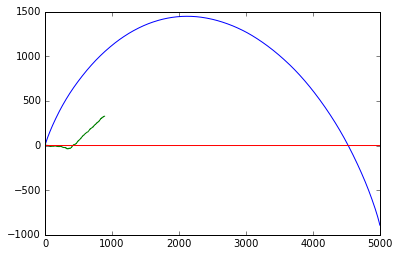

In [20]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(best)
plt.plot(reward)
plt.plot(random_reward)

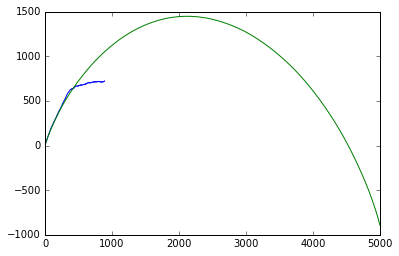

In [21]:
plt.plot(best[0:np.size(reward)]-reward)
plt.plot(best-random_reward)

In [ ]:
mW.eval()

In [ ]:
Cov2 = T.dot(mW, mW.T) + sigma[0]*T.identity_like(WWT)

In [ ]:
Cov2.eval()

In [ ]:
Cov.eval()